In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from scipy.stats import norm

import os
import pathlib

from Model import *
from utils import *

torch.autograd.set_detect_anomaly(True)
start_time=datetime.now().strftime('%B %d - %H:%M:%S')

In [2]:
#Global parameters
GlobalParams1=Params(param_type='k1',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.0005)
dB1 = SampleBMIncr(GlobalParams=GlobalParams1)
init_x1 =  Sample_Init(GlobalParams=GlobalParams1)
init_c1= torch.zeros_like(init_x1)

GlobalParams2=Params(param_type='k2',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.0005)
dB2 = SampleBMIncr(GlobalParams=GlobalParams2)   ## TODO: same dB?????
init_x2 =  Sample_Init(GlobalParams=GlobalParams2)
init_c2= torch.zeros_like(init_x2)

NT1=GlobalParams1.NT1
NT2=GlobalParams1.NT2
dt=GlobalParams1.dt
device=GlobalParams1.device
learning_rate = GlobalParams1.lr

#Forward Loss
forward_losses = []

#How many batches
MaxBatch= 500

#How many optimization steps per batch
OptimSteps= 25

#Train on a single batch?
single_batch = True

#Set up main models for y0 and z (z will be list of models)
v0_model_main1 = Network(scaler_type='sigmoid')
u0_model_main1 = Network(scaler_type='sigmoid')
y0_model_main1 = Network(scaler_type='sigmoid')

zv_models_main1 = [Network() for i in range(NT1)]
zu_models_main1 = [Network() for i in range(NT1)]
zy_models_main1 = [Network() for i in range(NT2)]
main_models1=Main_Models(GlobalParams=GlobalParams1)
main_models1.create(v0_model=v0_model_main1,
                    u0_model=u0_model_main1,
                    y0_model=y0_model_main1,
                    zv_models=zv_models_main1,
                    zu_models=zu_models_main1,
                    zy_models=zy_models_main1,
                    forward_loss=forward_losses,
                    dB=dB1,
                    init_x=init_x1,
                    init_c=init_c1)

v0_model_main2 = Network(scaler_type='sigmoid')
u0_model_main2 = Network(scaler_type='sigmoid')
y0_model_main2 = Network(scaler_type='sigmoid')

zv_models_main2 = [Network() for i in range(NT1)]
zu_models_main2 = [Network() for i in range(NT1)]
zy_models_main2 = [Network() for i in range(NT2)]
main_models2=Main_Models(GlobalParams=GlobalParams2)
main_models2.create(v0_model=v0_model_main2,
                    u0_model=u0_model_main2,
                    y0_model=y0_model_main2,
                    zv_models=zv_models_main2,
                    zu_models=zu_models_main2,
                    zy_models=zy_models_main2,
                    forward_loss=forward_losses,
                    dB=dB2,
                    init_x=init_x2,
                    init_c=init_c2)

pop1_dict={'dB':dB1,
           'init_x':init_x1 ,
           'init_c':init_c1 , 
           'GlobalParams':GlobalParams1, 
           'main_models':main_models1}

pop2_dict={'dB':dB2,
           'init_x':init_x2 ,
           'init_c':init_c2 , 
           'GlobalParams':GlobalParams2, 
           'main_models':main_models2}

In [3]:
#Define optimization parameters
params=[]
params = list(main_models1.v0_model.parameters())+\
         list(main_models1.u0_model.parameters())+\
         list(main_models1.y0_model.parameters())+\
         list(main_models2.v0_model.parameters())+\
         list(main_models2.u0_model.parameters())+\
         list(main_models2.y0_model.parameters())
for i in range(NT1):
    params += list(main_models1.zv_models[i].parameters())
    params += list(main_models1.zu_models[i].parameters())
    params += list(main_models2.zv_models[i].parameters())
    params += list(main_models2.zu_models[i].parameters())

for i in range(NT2):
    params += list(main_models1.zy_models[i].parameters())
    params += list(main_models2.zy_models[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adamax(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()
        loss = get_foward_loss(pop1_dict=pop1_dict, pop2_dict=pop2_dict)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=params,max_norm=0.7)
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):

        dB1 = SampleBMIncr(GlobalParams=GlobalParams1)
        init_x1 =  Sample_Init(GlobalParams=GlobalParams1)
        init_c1= torch.zeros_like(init_x1)
        pop1_dict={'dB':dB1,
                'init_x':init_x1 ,
                'init_c':init_c1 , 
                'GlobalParams':GlobalParams1, 
                'main_models':main_models1}

        dB2 = SampleBMIncr(GlobalParams=GlobalParams2)   ## TODO: same dB?????
        init_x2 =  Sample_Init(GlobalParams=GlobalParams2)
        init_c2= torch.zeros_like(init_x2)
        pop2_dict={'dB':dB2,
                'init_x':init_x2 ,
                'init_c':init_c2 , 
                'GlobalParams':GlobalParams2, 
                'main_models':main_models2}


Batch Number:  1
Average Error Est:  1.0603590393066407
Batch Number:  2
Average Error Est:  0.8804913234710693
Batch Number:  3
Average Error Est:  0.7637129855155945
Batch Number:  4
Average Error Est:  0.679110586643219
Batch Number:  5
Average Error Est:  0.6129391169548035
Batch Number:  6
Average Error Est:  0.5581848382949829
Batch Number:  7
Average Error Est:  0.5097621369361878
Batch Number:  8
Average Error Est:  0.46696999311447146
Batch Number:  9
Average Error Est:  0.4294584059715271
Batch Number:  10
Average Error Est:  0.39528855562210086
Batch Number:  11
Average Error Est:  0.3642099630832672
Batch Number:  12
Average Error Est:  0.33697122216224673
Batch Number:  13
Average Error Est:  0.31373440504074096
Batch Number:  14
Average Error Est:  0.2937713432312012
Batch Number:  15
Average Error Est:  0.2731513035297394
Batch Number:  16
Average Error Est:  0.256643693447113
Batch Number:  17
Average Error Est:  0.24239699602127074
Batch Number:  18
Average Error Est: 

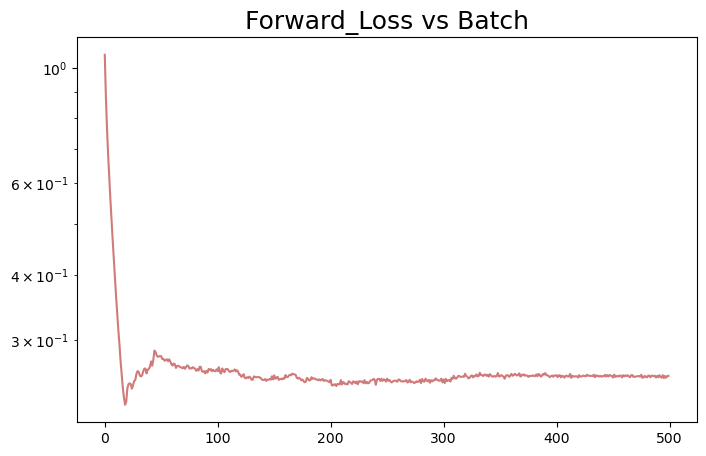

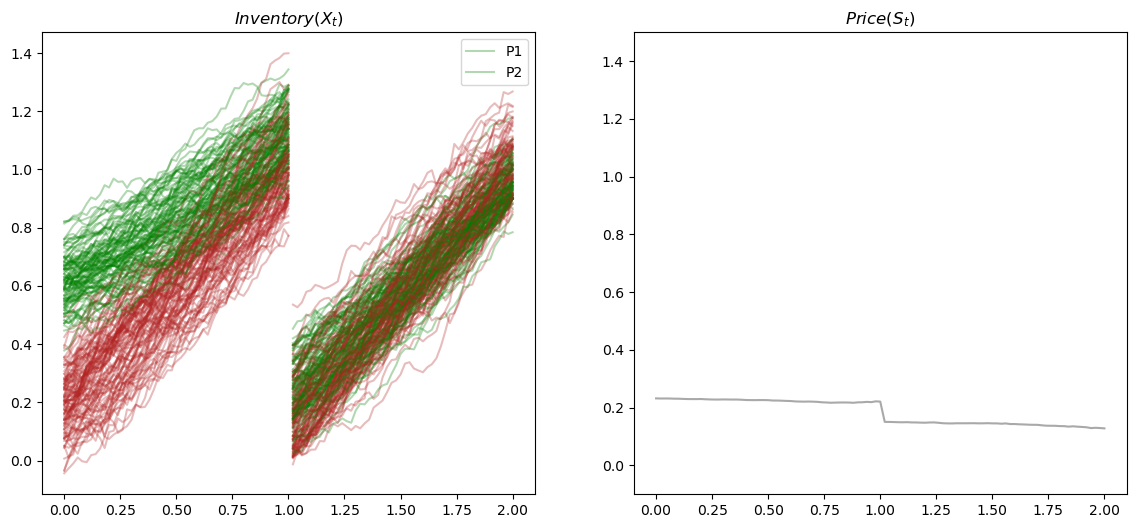

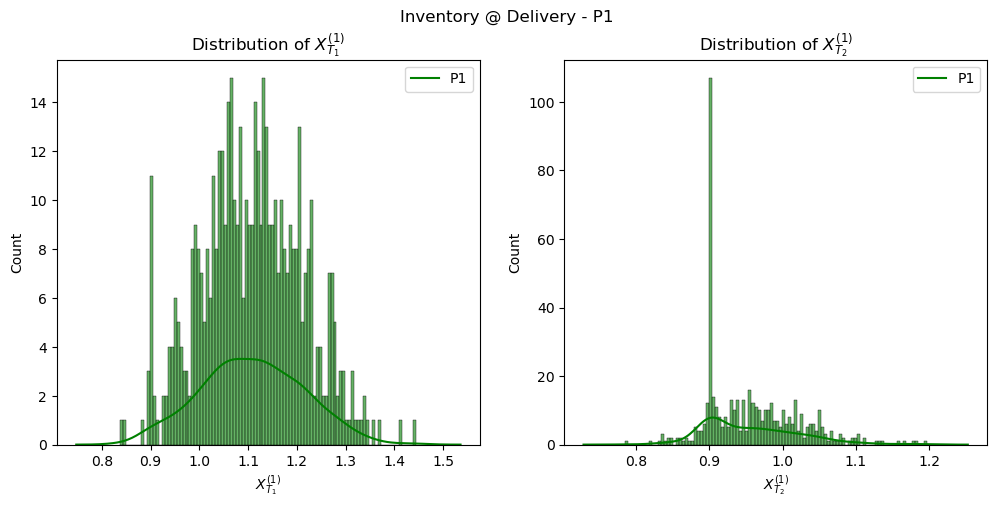

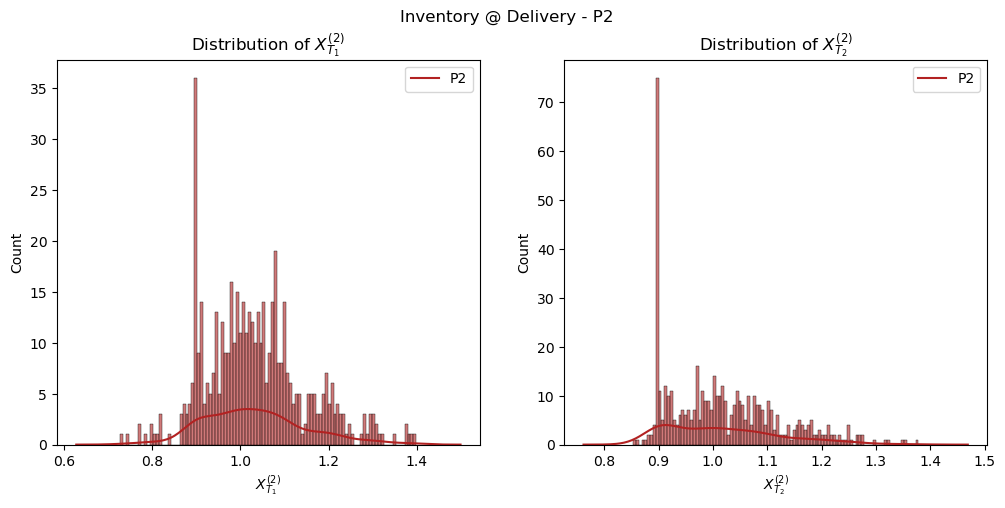

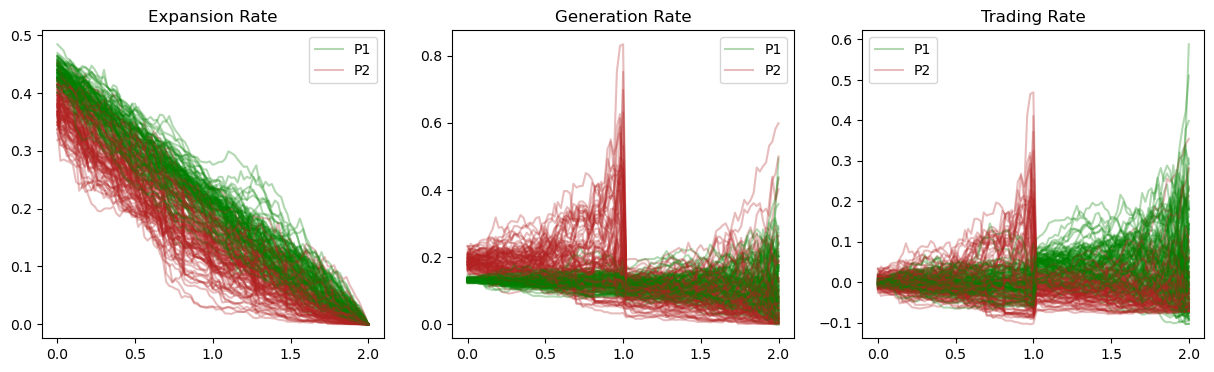

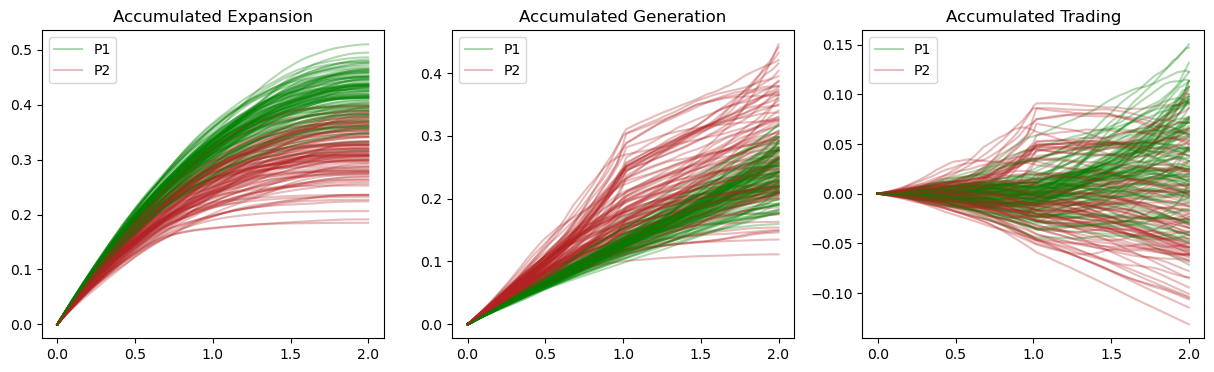

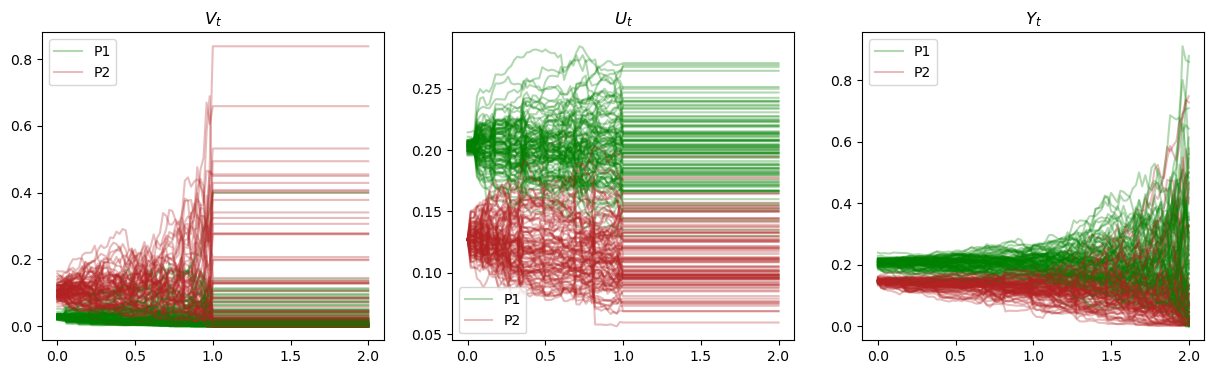

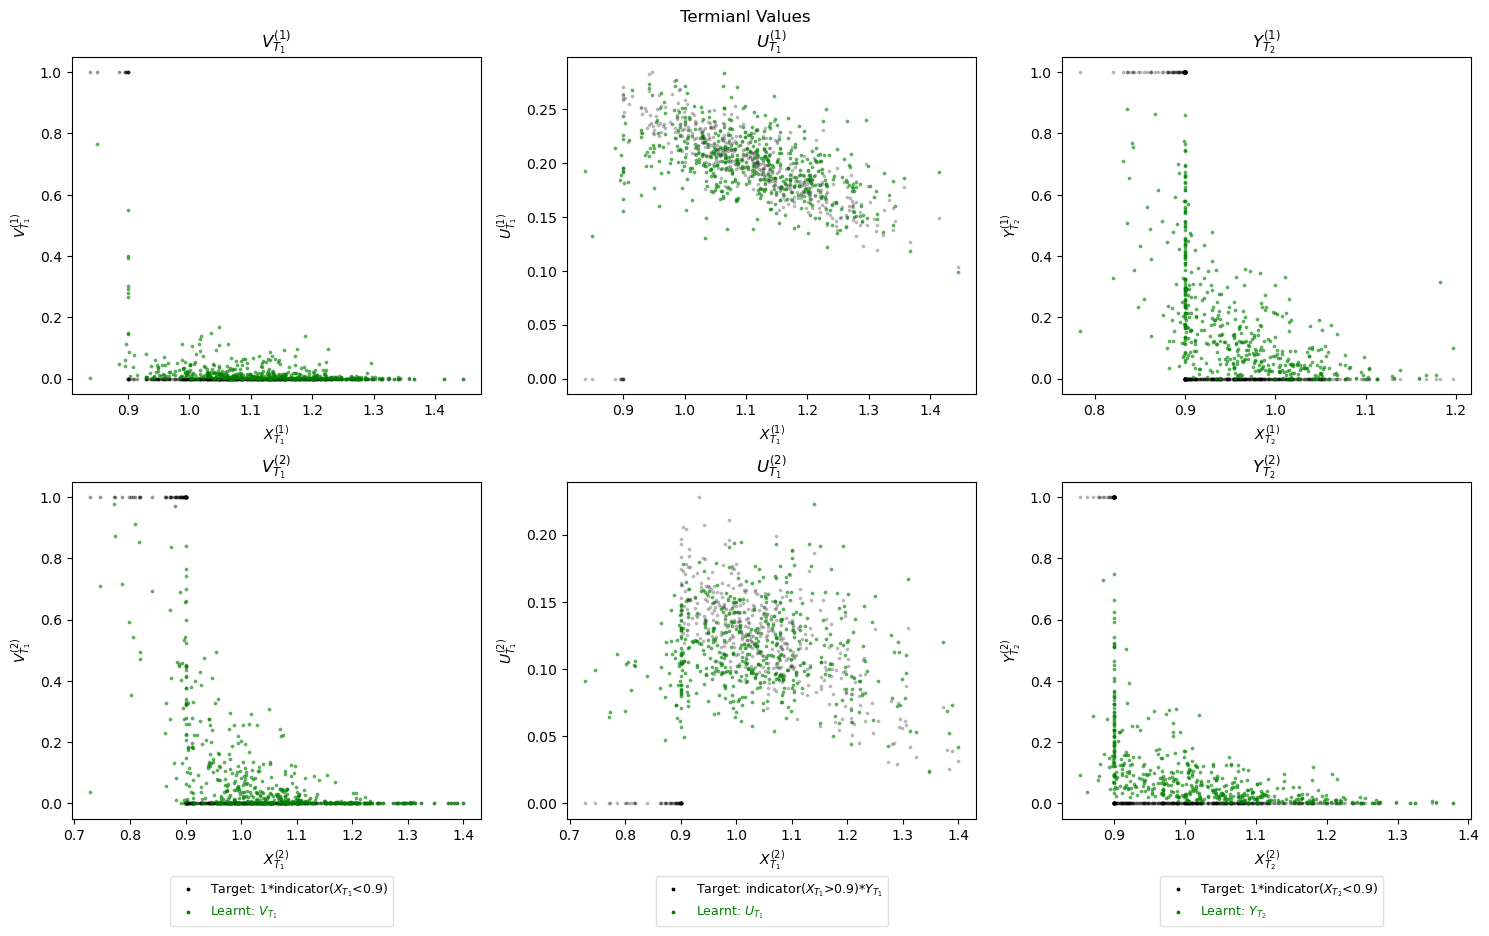

In [4]:
plot=plot_results(pop1_dict=pop1_dict, pop2_dict=pop2_dict, loss=forward_losses)
plot.FwdLoss(log=True)
plot.Inventory_And_Price()
plot.Decomposition_Inventory()
plot.Key_Processes()
plot.Terminal_Convergence()

## Save The Models

In [5]:
print(f"{len(main_models1.loss)} steps\nStarted @ {start_time}\nSaved @ {datetime.now().strftime('%B %d - %H:%M:%S')}")   ## to examine whether the loss attribute is updated in the module insteance
dir_path=pathlib.Path(os.getcwd(),
                      'Results',
                      'Best Models Saved',
                      'sigmoid_ind_0.0005lr_500steps_MSE_1w') # 0.25, 0.5, 0.75
dir_path.mkdir()
path1=pathlib.Path(dir_path,'pop1.pt')
path2=pathlib.Path(dir_path,'pop2.pt')
main_models1.save_entire_models(path=path1)
main_models2.save_entire_models(path=path2)

500 steps
Started @ September 16 - 10:34:56
Saved @ September 17 - 01:43:53


## Load The Model

In [6]:
# # GlobalParams1=Params(param_type='k1',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,K=0.9,lr=0.01)
# # GlobalParams2=Params(param_type='k2',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,K=0.9,lr=0.01)
# models1=Main_Models(GlobalParams=GlobalParams1)
# models2=Main_Models(GlobalParams=GlobalParams2)
# path_dir=pathlib.Path(os.getcwd(),
#                       "Results",
#                       "Best Models Saved",
#                       'sigmoid_ind_0.0005lr_500steps_MSE_0.25w')
# path1=pathlib.Path(path_dir,'pop1.pt')
# path2=pathlib.Path(path_dir,'pop2.pt')
# model_dict1=models1.load_entire_models(path=path1,overwrite=True)
# model_dict2=models2.load_entire_models(path=path2,overwrite=True)

# dB1=model_dict1['dB']
# init_x1=model_dict1['init_x']
# init_c1=model_dict1['init_c']
# pop1_dict= {'dB':dB1,
#             'init_x':init_x1 ,
#             'init_c':init_c1 ,
#             'GlobalParams':GlobalParams1, 
#             'main_models':models1}

# dB2=model_dict2['dB']
# init_x2=model_dict2['init_x']
# init_c2=model_dict2['init_c']

# pop2_dict= {'dB':dB2,
#             'init_x':init_x2 ,
#             'init_c':init_c2 , 
#             'GlobalParams':GlobalParams2, 
#             'main_models':models2}
# dt=GlobalParams1.dt
# NT1=GlobalParams1.NT1
# NT2=GlobalParams1.NT2
# NumTrain=GlobalParams1.NumTrain
# K=GlobalParams1.K
# loss=models1.loss

# plot=plot_results(pop1_dict=pop1_dict, pop2_dict=pop2_dict, loss=loss)
# plot.FwdLoss(log=True)
# plot.Inventory_And_Price()
# plot.Decomposition_Inventory()
# plot.Key_Processes()
# plot.Terminal_Convergence()
